<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/models/side_by_side.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
from keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import random

from google.colab import userdata

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [2]:
import torch.nn.functional as f


In [3]:
!pip install pytorch-msssim
from pytorch_msssim import ms_ssim

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

# 1. Set up project in runtime
Create colab secrets for the following credentials for the repo to get runtime files and clone repo

In [4]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}
!git clone https://{userdata.get('token')}@github.com/StuartLiv/CPSC-440-Project
%pwd

Cloning into 'CPSC-440-Project'...
remote: Enumerating objects: 166327, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 166327 (delta 33), reused 18 (delta 9), pack-reused 166262
Receiving objects: 100% (166327/166327), 775.12 MiB | 39.02 MiB/s, done.
Resolving deltas: 100% (36911/36911), done.
Updating files: 100% (249454/249454), done.


'/content'

# 2. Preprocess data

Datasets:
- `medset_multisize`
  - Single datasets. Dataset construction code in repo too
  - 12000 Images, in randomized order
  - Res 256x256 (grayscale images also available in 128x128, 64x64, 32x32)


Load datasets, partition sets, and make tensors in color-layer order for convolutions



In [5]:
start = 0.99

''' Returns an array containing first [proportion] of images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return array of images
'''
def make_image_arr(path):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)
  cutoff = int(len(files)*start)

  arr = []
  for i in tqdm(files[cutoff:]):
    img = load_img(path + '/'+i)
    arr.append(img_to_array(img) / 255)

  return np.array(arr)

'''
Axis transformation: Shape (n, h, w, 3) -> (n, 3, h, w)
Inversion is np.moveaxis(arr, [1,2], [3,1])
'''
def make_tensor(path):
  arr = make_image_arr(path)
  return torch.from_numpy(np.moveaxis(arr, [3,1], [1,2]))


#Extract single channel, since all 3 are the same in gray images
def make_gray_tensor(path):
  return make_tensor(path)[:, 0:1, :, :]

color = make_tensor('/content/CPSC-440-Project/datasets/medset_multisize/color')

gray032 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray32')
gray064 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray64')
gray128 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray128')
gray256 = make_gray_tensor('/content/CPSC-440-Project/datasets/medset_multisize/gray')


100%|██████████| 120/120 [00:00<00:00, 890.52it/s]


# 3. Model
Model generated below:

In [6]:
class Autoencoder(nn.Module):
    def __init__(self,intype):
        super(Autoencoder, self).__init__()
        # Encoder
        if intype == 'gray032':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
          )
        elif intype == 'gray064':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        elif intype == 'gray128':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        elif intype == 'gray256':
          self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
          )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 3, 3, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the emergent superesolutions autoencoders
esure032 = Autoencoder('gray032')
esure064 = Autoencoder('gray064')
esure128 = Autoencoder('gray128')
esure256 = Autoencoder('gray256')


Load stored decoder from full size model training, and fix decoder parameters.

In [7]:

esure032.encoder = torch.load('/content/CPSC-440-Project/models/32_dim_encoder_weights',map_location=device)
esure064.encoder = torch.load('/content/CPSC-440-Project/models/64_dim_encoder_weights',map_location=device)
esure128.encoder = torch.load('/content/CPSC-440-Project/models/128_dim_encoder_weights',map_location=device)
esure256.encoder = torch.load('/content/CPSC-440-Project/models/full_size_encoder_weights_256',map_location=device)


esures = [esure032,
          esure064,
          esure128,
          esure256,
          ]

for esure in esures:
  esure.decoder = torch.load('/content/CPSC-440-Project/models/decoder_weights_256',map_location=device)

Simple Image Space Exploration

i: 26


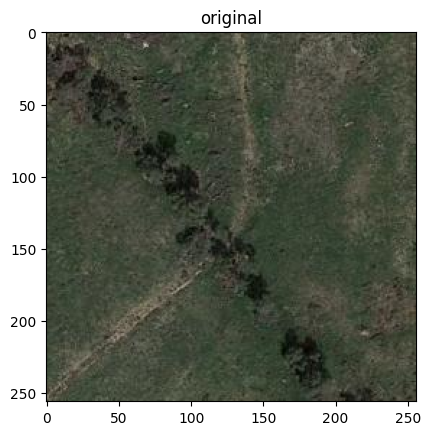

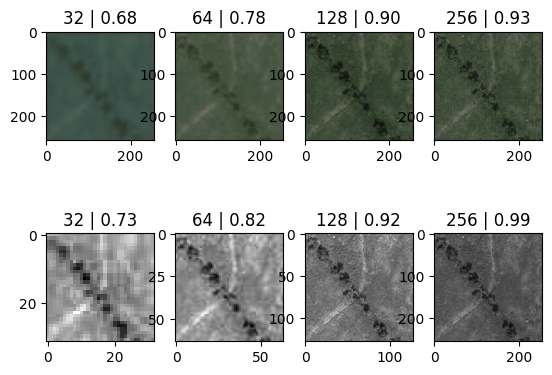

i: 92


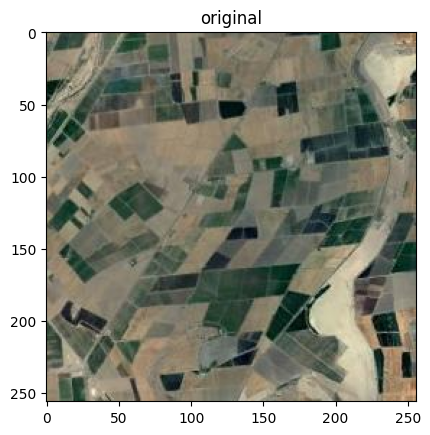

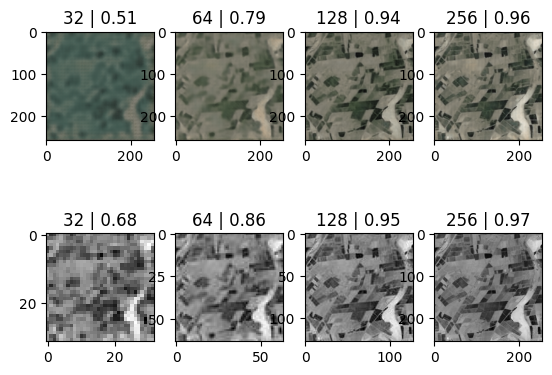

In [17]:
for esure in esures:
  esure.eval()
  esure.to(device)

with torch.no_grad():
  for i in np.random.randint(len(color),size=2):
    print("i:", i)

    target = color[i]
    im = np.moveaxis(target.numpy(), [0, 1, 2], [2, 0, 1])
    plt.imshow(im)
    plt.title('original')
    plt.show()

    inputs = [gray032[i], gray064[i], gray128[i], gray256[i]]
    dimlabels = [32,64,128,256]

    assert len(esures) == len(inputs) == len(dimlabels)

    for j in range(len(esures)):

      # Colorize the image
      t = inputs[j].unsqueeze(0).to(device)
      output = esures[j](t)
      colorized_image_format = np.moveaxis(output.squeeze().cpu().detach().numpy(), [1,2], [0,1])

      # Show and compute MSSIM for grey input
      upscaled = f.interpolate(inputs[j].reshape(1,1,dimlabels[j],dimlabels[j]),size=[256,256]) # upscale spatial dims to 256
      upscaled = upscaled.repeat(1,3,1,1) # duplicate color channels to 3
      input_mssim = ms_ssim(color[i].unsqueeze(0).to(device), upscaled.to(device), data_range=1, size_average=True) # return scalar

      plt.subplot(2,4,j+5)
      plt.imshow(inputs[j].numpy()[0],cmap='gray')
      plt.title(f'{dimlabels[j]} | {input_mssim:.2f}')

      # Show and compute MSSIM for outputs
      output_mssim = ms_ssim(color[i].unsqueeze(0).to(device), output, data_range=1, size_average=True) # return scalar

      plt.subplot(2,4,j+1)
      plt.imshow(colorized_image_format)
      plt.title(f'{dimlabels[j]} | {output_mssim:.2f}')

    plt.show()